# Cab G2M Case Study

The goal of this study is to conduct an exploratory data analysis with Python to find insights about two different cab companies, Yellow Cab and Pink Cab. These insights will help our client, company XYZ, choose which cab company to invest in. 

## Part 1: Load in Packages and Data

Before we can begin our study, we first nead to load in some helpful Python packages as well as the provided data.

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in data
cab_df = pd.read_csv('Cab_Data.csv')
city_df = pd.read_csv('City.csv')
cust_df = pd.read_csv('Customer_ID.csv')
transac_df = pd.read_csv('Transaction_ID.csv')

## Part 2: Data pre-processing

We now need to process our data so that it is ready to be analyzed. This is a multi-step process where the different raw data sets are combined to form one master data frame that we will use for our analysis.

The first thing we will do is to drop duplicate rows from each of the raw data frames before combining them. This is important because duplicate rows could make the results of the analysis misleading.

In [3]:
cab_df.drop_duplicates()
city_df.drop_duplicates()
cust_df.drop_duplicates()
transac_df.drop_duplicates();

The raw data may also include some NA values, which will cause problems in the analysis. So we will remove these values next. 

In [4]:
cab_df.dropna()
city_df.dropna()
cust_df.dropna()
transac_df.dropna();

Now that all 4 data frames only have unique rows without NA values, we can start combining them in appropriate ways and creating new features. 

## Part 3: Exploratory Data Analysis

We are now ready to perform EDA using our processed data to find key insights about the Pink and Yellow Cab companies. This will be accomplished by investigating several different hypotheses. To evaluate which cab company is the better prospect, we will focus on the following 3 key metrics:

1. Profits - which company makes more money
2. Customer reach - this is split into two parts:
    * Which company sells more rides in the most cities
    * Which company has a larger customer base when considering the following:
        * Gender
        * Age groups
        * Income levels
<br>
3. Customer retention - which company has more returning customers

The cab company that performs better across these 3 metrics is the company that XYZ should invest in.

### Hypothesis 1: The distributions of the profits of the two cab companies are different.

To investigate this hypothesis, we need to create a new feature, called "Profit". For the purpose of our analysis, we simply define profit as the difference between the cost of the trip and the price charged for the trip. Note that the "Price Charged" feature does appear to have some outliers, but we do not have sufficient evidence to conlcude that these values are incorrect. Therefore, they are still including in the analysis so that the provided data is fully represented. We will also create another feature, "Profit per KM", which we will use later.

In [5]:
# Generate Profit feature
cab_df['Profit'] = cab_df['Price Charged'] - cab_df['Cost of Trip'] 
cab_df['Profit per KM'] = cab_df['Profit'] / cab_df['KM Travelled'] 

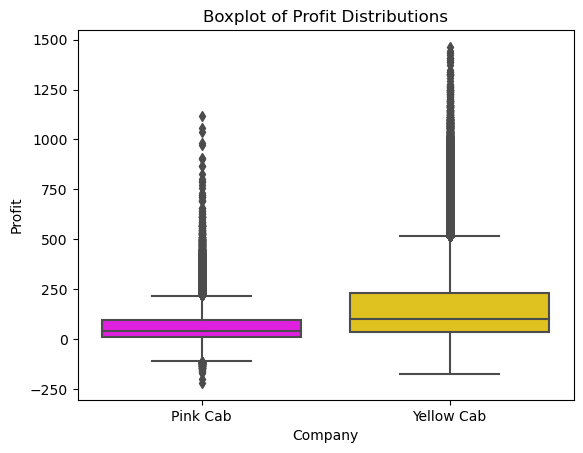

In [6]:
# Generate box plot
palette = {"Pink Cab":"fuchsia",
           "Yellow Cab":"gold"}
sns.boxplot(data=cab_df, x="Company", y="Profit", palette=palette).set(title="Boxplot of Profit Distributions");

The resulting boxplot shows that Yellow Cab has a higher median profit than Pink Cab. In fact, judging by the plot, the median profit of Yellow Cab is about the same as the upper quartile profit of Pink Cab. This indicates that Yellow Cab is significantly more profitable.

To examine this further, let us visualize the average profits for each company.

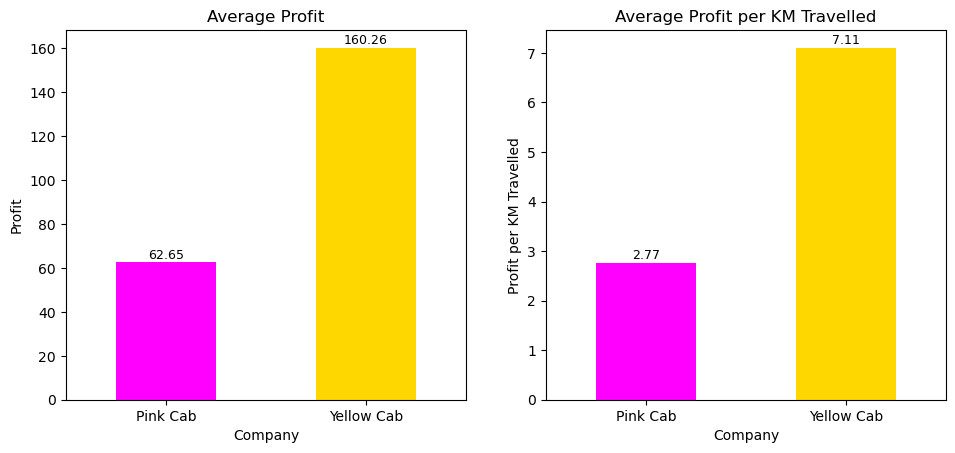

In [7]:
# Overall average profit
avg_profits = cab_df.groupby(['Company']).mean()['Profit']
plt.subplot(1, 2, 1)
plot1 = avg_profits.plot(kind='bar', ylabel = "Profit", title = "Average Profit", color = ["fuchsia", "gold"])
for bar in plot1.patches:
    plot1.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 5),
                   textcoords='offset points')

plt.xticks(rotation=0)


# Average profit per KM travelled
avg_profits = cab_df.groupby(['Company']).mean()['Profit per KM']
plt.subplot(1, 2, 2)
plot2 = avg_profits.plot(kind='bar', ylabel = "Profit per KM Travelled", title = "Average Profit per KM Travelled", color = ["fuchsia", "gold"])
for bar in plot2.patches:
    plot2.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 5),
                   textcoords='offset points')
plt.xticks(rotation=0)
plt.subplots_adjust(right=1.5);


The resulting bar plot shows that Yellow Cab reported about 2.6 times the overall average profit as well as about 2.6 times the average profit per KM travelled reported by Pink Cab for the years represented in the data. This clearly indicates that Yellow Cab makes higher profits. Our hypothesis that the distribution of profits is different for the two companies is correct. 

### Hypothesis 2: The profits vary with time.

The prior analysis doesn't give us the full picture. We want to take a closer look at how the profits of the two cab companies to see how they vary over time. Thus, the first thing we will do is to sort our data frame so that the profits are stored in chronological order.

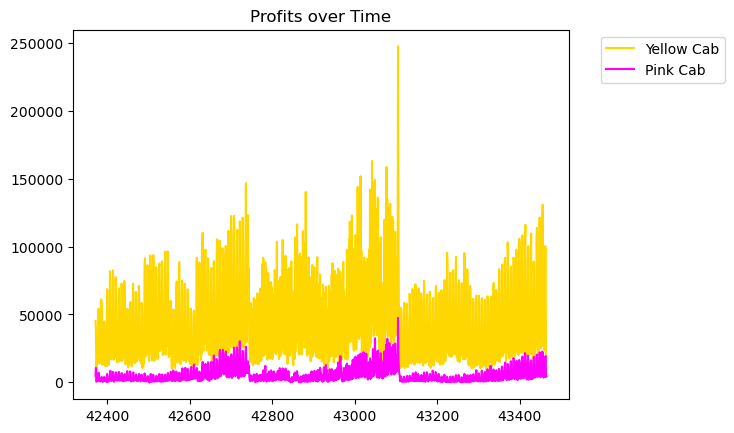

In [8]:
# Get Yellow Cab data
yellow = cab_df[cab_df['Company'] == "Yellow Cab"]

# Sort data chronologically
yellow.sort_values(by=['Date of Travel'])

# Sum profits for each date
yellow_summed = yellow.groupby(['Date of Travel']).sum()

# Generate plot
plt.plot(yellow_summed['Profit'], color="gold");

# Get Pink Cab data
pink = cab_df[cab_df['Company'] == "Pink Cab"]

# Sort data chronologically
pink.sort_values(by=['Date of Travel'])

# Sum profits for each date
pink_summed = pink.groupby(['Date of Travel']).sum()

# Generate plot
plt.plot(pink_summed['Profit'], color='fuchsia')
plt.legend(["Yellow Cab", "Pink Cab"], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Profits over Time");

The profits of both cab companies exhibit a similar pattern over time. Recently, it appears that profits have not been as high as in the past. The pattern is not smooth. Instead, it is rather turbulent, which indicates that profits change frequently with time. Therefore, our hypothesis is correct. However, the key thing to note here is that the profits of Yellow Cab are significantly higher than those for Pink Cab for the entirety of the time represented in the data set.

### Hypothesis 3: The location-wise proportion of profitable rides is usually different for the two companies (Yellow Cab usually has a higher proportion).

To investigate this hypothesis, we will create a new feature called "is_Profit" which stores a value of 1 if the company made a profit and 0 if the company made a loss. 

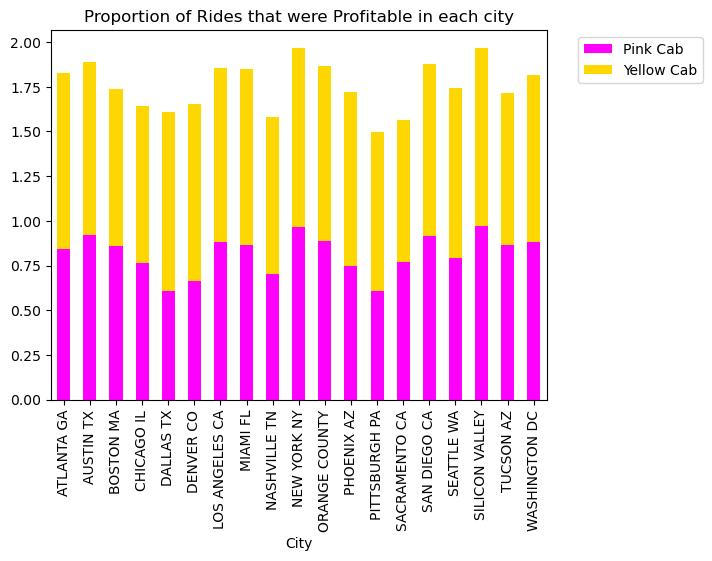

In [9]:
# Generate is_Profit feature
cab_df['is_Profit'] = np.where(cab_df['Profit'] > 0, 1, 0)
res = cab_df.groupby(['City', 'Company']).mean()
res = res.reset_index()

# Select columns and pivot table
new_res = res[['City', 'Company', 'is_Profit']]
new_res = new_res.pivot(index='City', columns='Company', values='is_Profit')

# Create plot
plot4 = new_res.plot(kind='bar', stacked=True, color=['fuchsia', 'gold'],
                    title="Proportion of Rides that were Profitable in each city")
plot4.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

The resulting plot shows the fraction of rides that made the companies a profit in each represented city. Overall, the pattern for both companies is quite similar, indicating that the city-wise percentage of profitable rides is usually about the same for both Pink Cab and Yellow Cab. Thus, our hypothesis is incorrect.

### Hypothesis 4: The two cab companies have an equal presence across all cities.

To investigate this hypothesis, we count the total trips for each cab company across all cities to investigate which company dominates which cities. 

But first, it may be useful to visualize which cities have more cab users. To do this, we will create a new feature from the City data frame. This feature will show the percentage of the city's population that uses cabs. To create this feature, we will have to convert the string variables in the City data frame to integer variables.

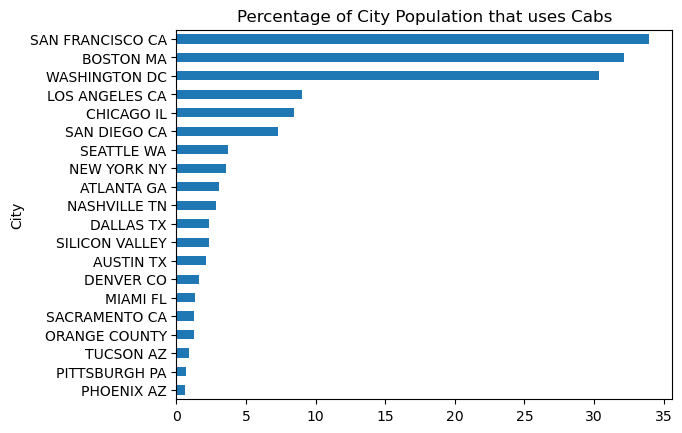

In [10]:
# Convert values to numeric data type
city_df['Users'] = pd.to_numeric(city_df['Users'].str.replace(',', ''))
city_df['Population'] = pd.to_numeric(city_df['Population'].str.replace(',', ''))

# Create pct feature
city_df['pct'] = city_df['Users'] / city_df['Population'] * 100
pct_df = city_df[['City', 'pct']]

# Sort data
pct_df = pct_df.sort_values('pct')

# Generate visualization of percentage of cab users in each city
plot = pct_df.plot.barh(x = 'City', y = 'pct', ylabel = 'Percentage', 
                 title = 'Percentage of City Population that uses Cabs', legend=False);

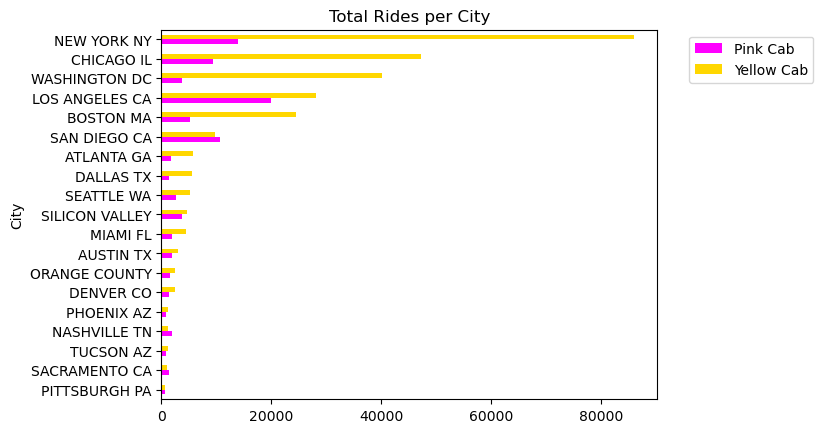

In [11]:
# Generate plot of total rides per city
result = cab_df.groupby(['Company', 'City'])['Company'].size().unstack(level=0)
result = result.sort_values('Yellow Cab')
plot2 = result.plot(kind='barh', title = "Total Rides per City", color={"Pink Cab": "fuchsia", "Yellow Cab": "gold"})
plot2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

This visualization indicates that Yellow Cab is the more popular choice in a majority of the cities. Yellow Cab serviced more rides in 15 of the 19 represented cities. Consequently, Pink Cab was the more popular option in only 4 cities. In New York, the city with the most cab rides in total, the diffence is especially striking. In fact, this visualization reveals a trend: cities that have a larger total number of cab rides are usually dominated by Yellow Cab. Additionally, consulting the first bar plot, we also see that cities in which a large portion of the population are cab users, such as Boston, Washington, LA, and Chicago, are dominated by Yellow Cab. San Diego is an exception since Pink Cab had more rides, but in this case the difference is relatively marginal. Our hypothesis that the two cab companies have an overall equal presence when considering all cities is wrong. Yellow Cab has a higher presence in most cities. Crucially, Yellow Cab has a higher presence in cities where larger portions of the population are cab users.

### Hypothesis 5: Different genders prefer different cab companies.

We want to compare the size of the customer base for the two cab companies for different genders. We do not need to make a new feature for this, since we have already been provided with this informtation. However, we do need to manipulate the data and do some joining to obtain the desired format.

In [12]:
# Merge cab, customer, and transaction data
df1 = cab_df.merge(transac_df, on = "Transaction ID")
df2 = df1.merge(cust_df, on = "Customer ID")

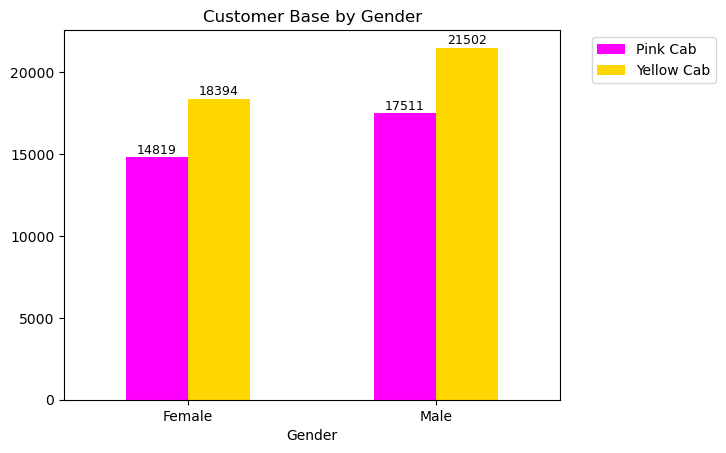

In [13]:
# Get Yellow Cab data
yellow = df2[df2['Company'] == "Yellow Cab"]

# Drop duplicate customer instances
df3 = yellow.drop_duplicates(subset='Customer ID', keep="first")

# Count no. of each gender
df4 = df3.groupby(['Gender']).count()

# Select just one column
df5 = pd.DataFrame(df4['Age'])

# Rename column
df5 = df5.rename(columns={'Age': 'Customers'})

# Get number of women
f_yellow = df5['Customers'][0]

# Get number of men
m_yellow = df5['Customers'][1]

# Repeat process for Pink Cab data
pink = df2[df2['Company'] == "Pink Cab"]
df6 = pink.drop_duplicates(subset='Customer ID', keep="first")
df7 = df6.groupby(['Gender']).count()
df8 = pd.DataFrame(df7['Age'])
df8 = df8.rename(columns={'Age': 'Customers'})
f_pink = df8['Customers'][0]
m_pink = df8['Customers'][1]

# Create new data frame with gender values
gen = {'Gender': ['Female', 'Male'], 'Pink Cab': [f_pink, m_pink], 'Yellow Cab': [f_yellow, m_yellow]}
gen_df = pd.DataFrame(gen)
gen_df = gen_df.set_index('Gender')

# Create plot
plot3 = gen_df.plot(kind='bar', title = "Customer Base by Gender", 
                    color={"Pink Cab": "fuchsia", "Yellow Cab": "gold"})
for bar in plot3.patches:
    plot3.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 5),
                   textcoords='offset points')
plot3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=0);

The resulting plot shows that men make up the majority of the customer base for both cab companies. However, the key takeaway is that Yellow Cab has a larger customer base for both genders. Thus, our hypothesis is incorrect, since the data shows that both more men and more women are Yellow Cab customers than Pink Cab customers.

### Hypothesis 6: Different age groups prefer different cab companies.

We want to compare the size of the customer base for the two cab companies for different ages. To investigate this hypothesis, we first have to make a new feature, called "Age Group". This feature will have four categories of age:

* 18 - 25 is "Young Adult"
* 26 - 39 is "Adult"
* 40 - 59 is "Older Adult"
* 60 and above is "Senior"

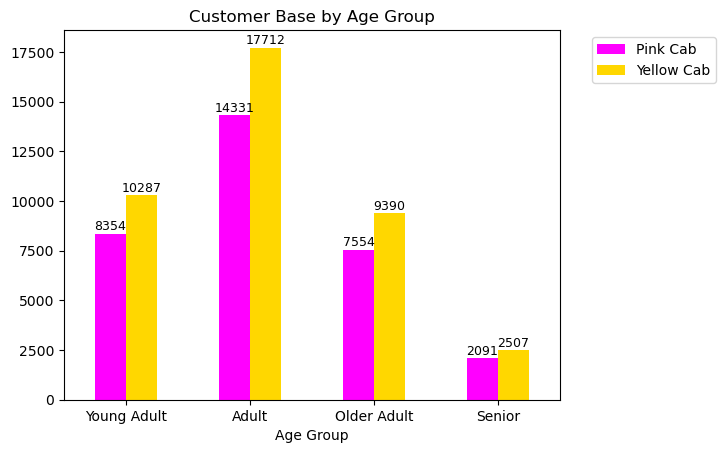

In [14]:
# Create conditions
conditions = [
    (df2['Age'] >= 18) & (df2['Age'] <= 25),
    (df2['Age'] >= 26) & (df2['Age'] <= 39),
    (df2['Age'] >= 40) & (df2['Age'] <= 59),
    (df2['Age'] >= 60)
    ]

# Set groups
groups = ['Young Adult', 'Adult', 'Older Adult', 'Senior']

# Generate age group feature
df2['Age Group'] = np.select(conditions, groups)

# Get Yellow Cab data
yellow = df2[df2['Company'] == "Yellow Cab"]

# Drop duplicate customer instances
df3 = yellow.drop_duplicates(subset='Customer ID', keep="first")

# Count no. of each age group
df4 = df3.groupby(['Age Group']).count()

# Select just one column
df5 = pd.DataFrame(df4['Age'])

# Rename column
df5 = df5.rename(columns={'Age': 'Customers'})

# Get number of adults
a_yellow = df5['Customers'][0]

# Get number of older adults
oa_yellow = df5['Customers'][1]

# Get number of seniors
s_yellow = df5['Customers'][2]

# Get number of young adults
ya_yellow = df5['Customers'][3]

# Repeat process for Pink Cab data
pink = df2[df2['Company'] == "Pink Cab"]
df6 = pink.drop_duplicates(subset='Customer ID', keep="first")
df7 = df6.groupby(['Age Group']).count()
df8 = pd.DataFrame(df7['Age'])
df8 = df8.rename(columns={'Age': 'Customers'})
a_pink = df8['Customers'][0]
oa_pink = df8['Customers'][1]
s_pink = df8['Customers'][2]
ya_pink = df8['Customers'][3]


# Create new data frame with age group values
ages = {'Age Group': ['Young Adult', 'Adult', 'Older Adult', 'Senior'], 
       'Pink Cab': [ya_pink, a_pink, oa_pink, s_pink], 
        'Yellow Cab': [ya_yellow, a_yellow, oa_yellow, s_yellow]}
ages_df = pd.DataFrame(ages)
ages_df = ages_df.set_index('Age Group')

# Create plot
plot5 = ages_df.plot(kind='bar', title = "Customer Base by Age Group", 
                     color={"Pink Cab": "fuchsia", "Yellow Cab": "gold"})
for bar in plot5.patches:
    plot5.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 5),
                   textcoords='offset points')
plot5.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=0);

The resulting plot shows that the majority of customers for both cab companies are in the "Adult" age group. However, the key insight here is that Yellow Cab has a larger customer base for all four age groups. Therefore, our hypothesis is wrong, as the evidence conveys that Yellow Cab is more popular than Pink Cab with customers of all ages.

### Hypothesis 7: Customers with different income levels prefer different cab companies.

We want to compare the size of the customer base for the two cab companies when considering income. To investigate this hypothesis, we first have to make a new feature, called "Income Level". This feature will have three categories of income:

* < 3000 USD/Month is "Low"
* 3000 - 20000 USD/Month is "Medium"
* Above 20000 USD/Month is "High"

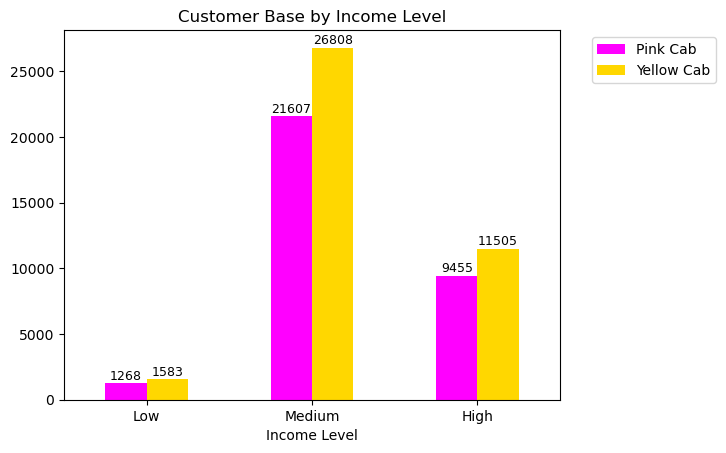

In [15]:
# Create conditions
conditions = [
    (df2['Income (USD/Month)'] < 3000),
    (df2['Income (USD/Month)'] >= 3000) & (df2['Income (USD/Month)'] <= 20000),
    (df2['Income (USD/Month)'] > 20000)
    ]

# Set groups
groups = ['Low', 'Medium', 'High']

# Generate income level feature
df2['Income Level'] = np.select(conditions, groups)

# Get Yellow Cab data
yellow = df2[df2['Company'] == "Yellow Cab"]

# Drop duplicate customer instances
df3 = yellow.drop_duplicates(subset='Customer ID', keep="first")

# Count no. of each income level
df4 = df3.groupby(['Income Level']).count()

# Select just one column
df5 = pd.DataFrame(df4['Age'])
df5

# Rename column
df5 = df5.rename(columns={'Age': 'Customers'})

# Get number of high income earners
h_yellow = df5['Customers'][0]

# Get number of low income earners
l_yellow = df5['Customers'][1]

# Get number of medium income earners
m_yellow = df5['Customers'][2]

# Repeat process for Pink Cab data
pink = df2[df2['Company'] == "Pink Cab"]
df6 = pink.drop_duplicates(subset='Customer ID', keep="first")
df7 = df6.groupby(['Income Level']).count()
df8 = pd.DataFrame(df7['Age'])
df8 = df8.rename(columns={'Age': 'Customers'})
h_pink = df8['Customers'][0]
l_pink = df8['Customers'][1]
m_pink = df8['Customers'][2]


# Create new data frame with income level values
incomes = {'Income Level': ['Low', 'Medium', 'High'], 
       'Pink Cab': [l_pink, m_pink, h_pink], 
        'Yellow Cab': [l_yellow, m_yellow, h_yellow]}
incomes_df = pd.DataFrame(incomes)
incomes_df = incomes_df.set_index('Income Level')

# Create plot
plot6 = incomes_df.plot(kind='bar', title = "Customer Base by Income Level", 
                        color={"Pink Cab": "fuchsia", "Yellow Cab": "gold"})
for bar in plot6.patches:
    plot6.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 5),
                   textcoords='offset points')
plot6.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=0);

The resulting plot shows that the majority of customers for both cab companies are medium income earners. This makes sense. It is likely difficult for low income earners to afford to hire cabs. Meanwhile, high income earners probably prefer to use their own cars for commutes. However, the key insight here is that Yellow Cab has a larger customer base for all three income levels. Therefore, our hypothesis is wrong, as the evidence conveys that Yellow Cab is more popular than Pink Cab with customers of all income categories.

### Hypothesis 8: Based on the preceding analysis, Yellow Cab has higher customer retention than Pink Cab.

The preceding analysis suggests that Yellow Cab is more successful than Pink Cab when considering multiple different metrics. It is therefore reasonable to deduce that Yellow Cab offers superior service, and thus retains more customers than Pink Cab. This hypothesis is investigated below. 

For this analysis, we have to make a new feature called "Customers Retained". For our purposes, we consider a customer as being retained if they enlisted the services of the same cab company more than 5 times in the given time period. We will need to do some Pandas manipulation to extract the data into a form that we can visualize.

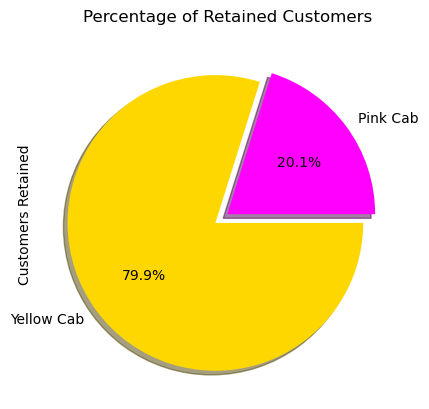

In [16]:
# Get Yellow Cab data
yellow = df2[df2['Company'] == "Yellow Cab"]

# Count customer instances
df7 = yellow.groupby(['Customer ID']).count()

# Select just one column
df8 = pd.DataFrame(df7['Age'])

# Rename column
df8 = df8.rename(columns={'Age': 'No. of Rides'})

# Get customers that purchased more than 5 rides
df9 = df8[df8['No. of Rides'] > 5]

# Get Pink Cab data
pink = df2[df2['Company'] == "Pink Cab"]
df10 = pink.groupby(['Customer ID']).count()
df11 = pd.DataFrame(df10['Age'])
df11 = df11.rename(columns={'Age': 'No. of Rides'})
df12 = df11[df11['No. of Rides'] > 5]


# Create new data frame with Customers Retained feature
ret = {'Company': ['Pink Cab', 'Yellow Cab'], 'Customers Retained': [df12.shape[0], df9.shape[0]]}
ret_df = pd.DataFrame(ret)
ret_df = ret_df.set_index('Company')
plot7 = ret_df.plot.pie(y="Customers Retained", title='Percentage of Retained Customers', 
                      explode=(0, 0.1), legend = False, shadow=True, autopct='%1.1f%%', 
                      colors = ['fuchsia', 'gold'])

The final pie chart visualization clearly shows that Yellow Cab exhibits higher customer retention levels than Pink Cab. When considering all customers who purchased more than 5 rides from the same cab company, 79.9% of these customers belong to Yellow Cab, whereas only 20.1% belong to Pink Cab. Thus, Yellow Cab has a customer retention rate that is approximately 4 times more than the rate for Pink Cab. Therefore, our hypothesis is correct.

## Part 4: Summary of EDA Results and Recommendation

Our results in the context of our 3 key metrics are summarized below:

Profit:
* The city-wise percentage of profitable rides is about the same for both companies
* Yellow Cab has a higher overall average profit and average profit per KM travelled (in both cases, about 2.6 times more profitable)
* Yellow Cab was significantly more profitable for the entire time period represented in the data set
* Based on the above points, Yellow Cab wins in the profit category

Customer reach:
* Yellow Cab services more rides in the majority of the cities represented in the data set
* In New York, the city with the most cab rides overall, Yellow Cab was the more popular choice by a large margin
* Yellow Cab has a higher presence in cities where larger portions of the population are cab users
* Yellow Cab has a larger customer base for both genders
* Yellow Cab has a larger customer base for all age groups
* Yellow Cab has a larger customer base for all income levels
* Based on the above points, Yellow Cab wins in the customer reach category


Customer retention:
* Yellow Cab exhibits higher customer retention levels than Pink Cab (about 4 times more)
* Based on the above point, Yellow Cab wins in the customer retention category

Our analysis has shown that Yellow Cab is the winning candidate for all 3 of our chosen evaluation metrics. Thus, our recommendation is that XYZ should invest in Yellow Cab, since the evidence indicates that this would result in a much better ROI than investing in Pink Cab.